In [1]:
# imports
import re

import unicodedata
import nltk
import nltk.sentiment
from wordcloud import WordCloud

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# local
from env import get_db_url
import acquire as a
import prepare as p

# Exercises

## 1. Spam Data

- Load the spam data set.


In [2]:
# Get SQL database url
url = get_db_url('spam_db')
# Define SQL query
query = '''
        SELECT *
        FROM spam
        '''

In [3]:
# Read SQL
df = pd.read_sql(query, url, index_col='id')
df.head()

label                                               text
id                                                         
0    ham  Go until jurong point, crazy.. Available only ...
1    ham                      Ok lar... Joking wif u oni...
2   spam  Free entry in 2 a wkly comp to win FA Cup fina...
3    ham  U dun say so early hor... U c already then say...
4    ham  Nah I don't think he goes to usf, he lives aro...

In [4]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', '4', 'ltgt']

def clean(text):
    '''
    A simple function to cleanup text data.
    
    Args:
        text (str): The text to be cleaned.
        
    Returns:
        list: A list of lemmatized words after cleaning.
    '''
    
    # basic_clean() function from last lesson:
    # Normalize text by removing diacritics, encoding to ASCII, decoding to UTF-8, and converting to lowercase
    text = (unicodedata.normalize('NFKD', text)
            .encode('ascii', 'ignore')
            .decode('utf-8', 'ignore')
            .lower())

    # Remove punctuation, split text into words
    words = re.sub(r'[^\w\s]', '', text).split()


    # lemmatize() function from last lesson:
    # Initialize WordNet lemmatizer
    wnl = nltk.stem.WordNetLemmatizer()

    # Combine standard English stopwords with additional stopwords
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS

    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [5]:
# we can do that process with a join on a Series and not just a list
# we will do that for ham words, spam words, and all words
# we will pass our basic cleaning on top of that

ham_words = clean(' '.join(df[df.label=="ham"]['text']))
spam_words = clean(' '.join(df[df.label=="spam"]['text']))
all_words = clean(' '.join(df['text']))

In [6]:
len(all_words), len(spam_words), len(ham_words)

(50018, 12044, 37974)

- Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?


In [7]:
spam_bi = pd.Series(nltk.bigrams(spam_words))
spam_bi = spam_bi.apply(lambda row: '_'.join([str(x) for x in row]))
spam_bi.head()

0    free_entry
1    entry_wkly
2     wkly_comp
3      comp_win
4        win_fa
dtype: object

<Axes: >

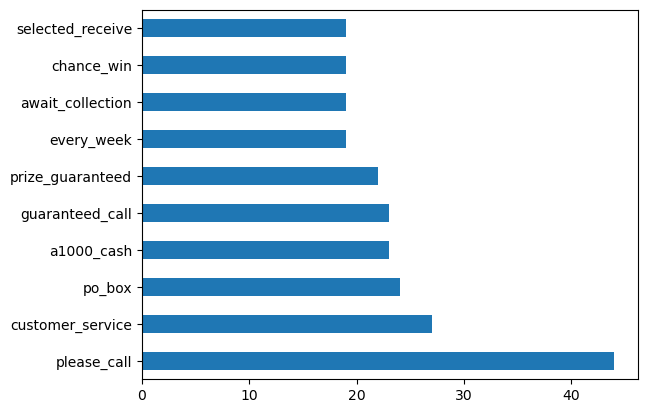

In [8]:
spam_bi.value_counts().head(10).plot.barh()

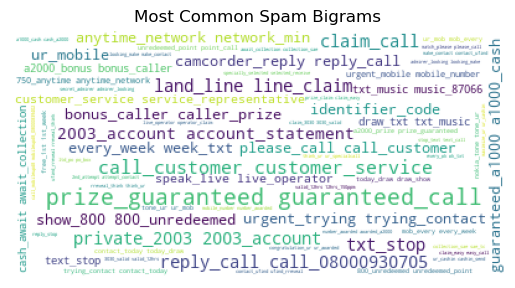

In [9]:
img = WordCloud(background_color='white').generate(' '.join(spam_bi))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common Spam Bigrams')
plt.show()

In [10]:
ham_bi = pd.Series(nltk.bigrams(ham_words))
ham_bi = ham_bi.apply(lambda row: '_'.join([str(x) for x in row]))
ham_bi.head()

0          go_jurong
1       jurong_point
2        point_crazy
3    crazy_available
4    available_bugis
dtype: object

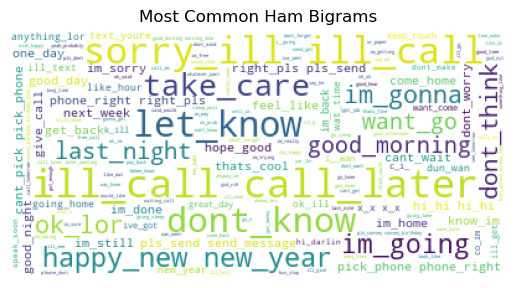

In [11]:
img = WordCloud(background_color='white').generate(' '.join(ham_bi))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common Ham Bigrams')
plt.show()

- Is there any overlap in the bigrams for the spam data and the ham data?


In [12]:
ham_bi_freq = pd.Series(ham_bi).value_counts()
spam_bi_freq = pd.Series(spam_bi).value_counts()

am_counts = pd.concat([ham_bi_freq, spam_bi_freq], axis=1).fillna(0).astype(int)

# rename the col names
am_counts.columns = ['ham', 'spam']
am_counts = am_counts.sort_values(['spam','ham'], ascending=False)
am_counts.head()

ham  spam
please_call         9    44
customer_service    2    27
po_box              1    24
a1000_cash          0    23
guaranteed_call     0    23

In [13]:
am_counts[(am_counts.ham>0) & (am_counts.spam>0)].head(10)

ham  spam
please_call         9    44
customer_service    2    27
po_box              1    24
every_week          2    19
send_stop           1    19
free_call           6    14
tell_ur             1    14
mobile_number       1    11
call_free           2     9
think_ur            1     9

- Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.


In [14]:
spam_tri = pd.Series(nltk.trigrams(spam_words))
spam_tri = spam_tri.apply(lambda row: '_'.join([str(x) for x in row]))
spam_tri.head()

0    free_entry_wkly
1    entry_wkly_comp
2      wkly_comp_win
3        comp_win_fa
4         win_fa_cup
dtype: object

In [15]:
ham_tri = pd.Series(nltk.trigrams(ham_words))
ham_tri = ham_tri.apply(lambda row: '_'.join([str(x) for x in row]))
ham_tri.head()

0          go_jurong_point
1       jurong_point_crazy
2    point_crazy_available
3    crazy_available_bugis
4        available_bugis_n
dtype: object

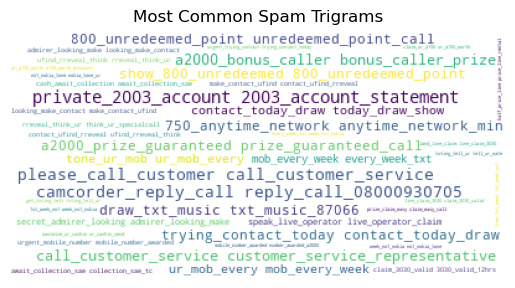

In [16]:
img = WordCloud(background_color='white').generate(' '.join(spam_tri))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common Spam Trigrams')
plt.show()

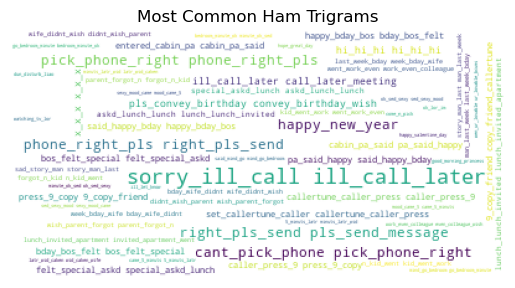

In [17]:
img = WordCloud(background_color='white').generate(' '.join(ham_tri))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common Ham Trigrams')
plt.show()

In [18]:
ham_tri_freq = pd.Series(ham_tri).value_counts()
spam_tri_freq = pd.Series(spam_tri).value_counts()

am_tri_counts = pd.concat([ham_tri_freq, spam_tri_freq], axis=1).fillna(0).astype(int)

# rename the col names
am_tri_counts.columns = ['ham', 'spam']
am_tri_counts = am_tri_counts.sort_values(['spam','ham'], ascending=False)
am_tri_counts[(am_tri_counts.ham>0) & (am_tri_counts.spam>0)]

ham  spam
please_call_back       1     4
sorry_missed_call      2     1
called_left_message    1     1
new_year_eve           1     1
number_im_glad         1     1

## 2. Explore the blog articles using the techniques discussed in the exploration lesson.



In [19]:
df = a.get_all_blog_articles()
df

title  \
0    Spotlight on APIDA Voices: Celebrating Heritag...   
1    Women in tech: Panelist Spotlight – Magdalena ...   
2    Women in tech: Panelist Spotlight - Rachel Rob...   
3    Women in Tech: Panelist Spotlight - Sarah Mell...   
4    Women in Tech: Panelist Spotlight - Madeleine ...   
..                                                 ...   
157       How Codeup Prepared Me for a Career - Codeup   
158               Why I'm Thankful for Codeup - Codeup   
159  Finding the Perfect Coding Bootcamp Fit for Me...   
160          Codeup Student Check In: Month 3 - Codeup   
161    From Styling Hair to Stying Interfaces - Codeup   

                                               content  \
0    \nMay is traditionally known as Asian American...   
1    \nWomen in tech: Panelist Spotlight – Magdalen...   
2    \nWomen in tech: Panelist Spotlight – Rachel R...   
3    \nWomen in tech: Panelist Spotlight – Sarah Me...   
4    \nWomen in tech: Panelist Spotlight – Madelein...   
..                                                 ...   
157  \nBy Joyce Yueh Yueh Ling\nIn four months, a l...   
158  \nBy Amy Yanaway\n \nAlmost every day since gr...   
159  \n \n\n\nBy Marcella Munter\nI looked at Codeu...   
160  \nCodeup welcomed the Wrangell cohort on July ...   
161  \nBy Sukari Schutzman\nI grew up loving techno...   

                                  category  
0                                 Featured  
1                         Events, Featured  
2                         Events, Featured  
3                    Codeup News, Featured  
4                         Events, Featured  
..                                     ...  
157                         Alumni Stories  
158                         Alumni Stories  
159                         Alumni Stories  
160                            Codeup News  
161  Alumni Stories, Behind the Billboards  

[162 rows x 3 columns]

In [20]:
pd.set_option('display.max_colwidth',None)

In [21]:
# rename content to original
df = df.rename(columns={'content':'original'})
# Derive column 'clean' from column: 'original'
df.insert(2, 'clean', df.apply(lambda row : p.remove_stopwords(p.tokenize(p.basic_clean(row.original))), axis=1))
# Derive column 'stemmed' from column: 'original'
df.insert(3, 'stemmed', df.apply(lambda row : p.stem(row.clean), axis=1))
# Derive column 'lemmatized' from column: 'original'
df.insert(4, 'lemmatized', df.apply(lambda row : p.lemmatize(row.clean), axis=1))
df.sample(1)

title  \
37  Free JavaScript Workshop at Codeup Dallas on 6/28 - Codeup   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    original  \
37  \n\n\n\n\n\nEvent Info: \nLocation – Codeup Dallas\nTime – 6 pm \nCome Learn JavaScript\nJoin us for our live in-person JavaScript crash course, where we will dig into one of the fastest-growing languages in the software development industry. It’s free and open to all – you don’t need to have any previous programming knowledge to participate. \nBy the end of the presentation, you will:\n\nHave a good understanding of what programming means\nKnow what JavaScript is and how it’s used\nThe best part: we will get our hands dirty writing some JavaScript. \n\nDon’t worry…we’ll walk you through every step. Come learn to code live with our very own instructor staff. Maybe this will be your jumpstart into an exciting and in-demand career…for FREE! \nParking\nYou can park inside our gragae at our building! Just take a ticket. Once our workshop is over you can stop by the security desk and they will validate your parking for you. \nMust be 18+ to participate. \n\n\n\n\n\n\n\n \n\n   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      clean  \
37  event info location codeup dallas time 6 pm come learn javascript join us live person javascript crash course dig one fastest growing languages software development industry free open dont need previous programming knowledge participate end presentation good understanding programming means know javascript used best part get hands dirty writing javascript dont worry well walk every step come learn code live instructor staff maybe jumpstart exciting demand career free parking park inside gragae building take ticket workshop stop security desk validate parking must 18 participate   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   stemmed  \
37  event info locat codeup dalla time 6 pm come learn javascript join us live person javascript crash cours dig one fastest grow languag softwar develop industri free open dont need previou program knowledg particip end present g

In [22]:
df['news'] = np.where(df.category.str.contains('News'),'News','Other')
df.head(1)

title  \
0  Spotlight on APIDA Voices: Celebrating Heritage and Inspiring Change ft. Arbeena Thapa   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [23]:
news_blogs = [word for row in df[df.news=="News"]['lemmatized'] for word in row.split()]
other_blogs = [word for row in df[df.news=="Other"]['lemmatized'] for word in row.split()]
all_blogs = [word for row in df['lemmatized'] for word in row.split()]

In [24]:
len(all_blogs), len(other_blogs), len(news_blogs)

(47170, 32658, 14512)

In [25]:
news_freq = pd.Series(news_blogs).value_counts()
other_freq = pd.Series(other_blogs).value_counts()
all_freq = pd.Series(all_blogs).value_counts()

In [26]:
news_freq.head()

codeup     285
career     147
tech       139
student    128
program    126
dtype: int64

In [27]:
other_freq.head()

data       489
codeup     421
career     290
job        280
science    236
dtype: int64

In [28]:
word_counts = pd.concat([news_freq, other_freq], axis=1).fillna(0).astype(int)
word_counts.columns = ['news', 'other']
word_counts.head()

news  other
codeup    285    421
career    147    290
tech      139    161
student   128    137
program   126    232

In [29]:
word_counts.sort_values('news',ascending=False)

news  other
codeup       285    421
career       147    290
tech         139    161
student      128    137
program      126    232
...          ...    ...
text           0      2
vulnerable     0      2
reliance       0      2
reduce         0      2
eternally      0      1

[5835 rows x 2 columns]

<Axes: >

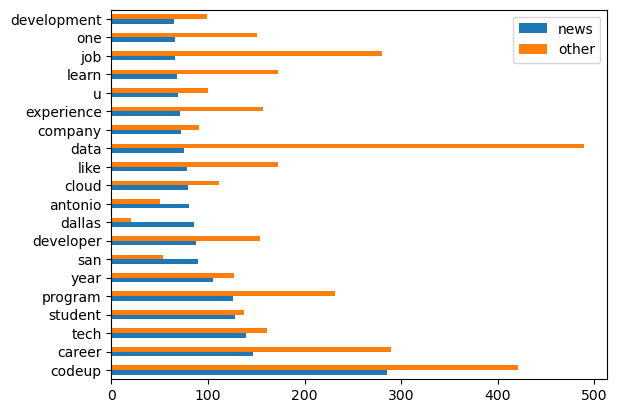

In [30]:
word_counts.sort_values('news', ascending=False).head(20).plot.barh()

In [31]:
word_counts.sort_values('news', ascending=False).head(20)\
.apply(lambda row: row/sum(row), axis=1)

news     other
codeup       0.403683  0.596317
career       0.336384  0.663616
tech         0.463333  0.536667
student      0.483019  0.516981
program      0.351955  0.648045
year         0.452586  0.547414
san          0.629371  0.370629
developer    0.363636  0.636364
dallas       0.811321  0.188679
antonio      0.615385  0.384615
cloud        0.415789  0.584211
like         0.310757  0.689243
data         0.132979  0.867021
company      0.441718  0.558282
experience   0.311404  0.688596
u            0.408284  0.591716
learn        0.283333  0.716667
job          0.190751  0.809249
one          0.304147  0.695853
development  0.396341  0.603659

In [32]:
sia = nltk.sentiment.SentimentIntensityAnalyzer()

In [33]:
df['sentiment'] = df['original'].apply(lambda doc: sia.polarity_scores(doc)['compound'])
df.head()

title  \
0  Spotlight on APIDA Voices: Celebrating Heritage and Inspiring Change ft. Arbeena Thapa   
1                                    Women in tech: Panelist Spotlight – Magdalena Rahn -   
2                              Women in tech: Panelist Spotlight - Rachel Robbins-Mayhill   
3                               Women in Tech: Panelist Spotlight - Sarah Mellor - Codeup   
4                           Women in Tech: Panelist Spotlight - Madeleine Capper - Codeup   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [34]:
df.groupby('category').sentiment.agg(['mean','median'])

mean  \
category                                                                                                                       
Alumni Stories                                                                                                      0.992746   
Alumni Stories, Behind the Billboards                                                                               0.998000   
Alumni Stories, Dallas Newsletter                                                                                   0.985900   
Alumni Stories, Dallas, Events, Featured, Military, San Antonio, Veterans, Virtual, Workshops                       0.959400   
Alumni Stories, Full Stack Web Development                                                                          0.991300   
Behind the Billboards                                                                                               0.000000   
Behind the Billboards, Data Science                                                                                 0.999600   
Behind the Billboards, Tips for Prospective Students                                                                0.996800   
Cloud Administration                                                                                                0.990000   
Cloud Administration, Data Science, Featured, Financing, Full Stack Web Development, Tips for Prospective Students  0.993600   
Cloud Administration, Data Science, Featured, Full Stack Web Development                                            0.971400   
Cloud Administration, Tips for Prospective Students                                                                 0.990300   
Codeup News                                                                                                         0.888988   
Codeup News, Dallas Newsletter                                                                                      0.763760   
Codeup News, Dallas Newsletter, Featured                                                                            0.960700   
Codeup News, Dallas Newsletter, Featured, Tips for Prospective Students                                             0.991600   
Codeup News, Employers                                                                                              0.986429   
Codeup News, Events                                                                                                 0.992200   
Codeup News, Events, Featured                                                                                       0.989167   
Codeup News, Featured                                                                                               0.973240   
Codeup News, Featured, IT Training                                                                                  0.997500   
Codeup News, Featured, IT Training, Tips for Prospective Students                                                   0.999300   
Codeup News, Full Stack Web Development                                                                             0.995200   
Codeup News, Tips for Prospective Students                                                                          0.998600   
Cybersecurity                                                                                                       0.994900   
Dallas Info                                                                                                         0.993600   
Dallas Newsletter                                                                                                   0.843300   
Dallas Newsletter, Full Stack Web Development                                                                       0.987000   
Dallas, Dallas Newsletter, Events, Workshops                                                                        0.957600   
Dallas, Dallas Newsletter, Workshops                                                                                0.955300   
Dallas, San Antonio, Vir

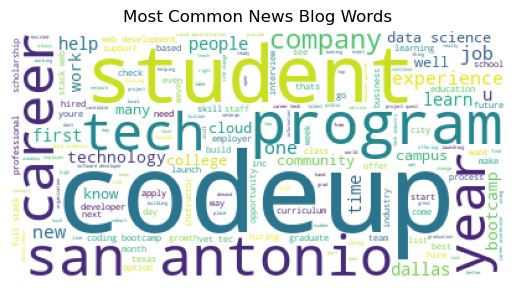

In [35]:
img = WordCloud(background_color='white').generate(' '.join(news_blogs))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common News Blog Words')
plt.show()

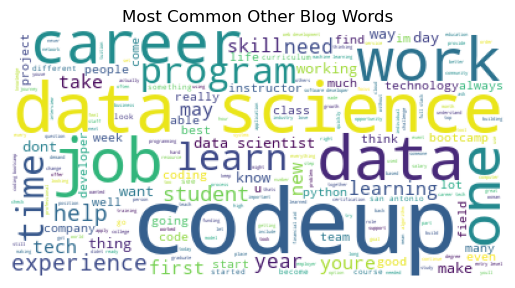

In [36]:
img = WordCloud(background_color='white').generate(' '.join(other_blogs))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common Other Blog Words')
plt.show()

In [37]:
news_bi = pd.Series(nltk.bigrams(news_blogs))
news_bi = news_bi.apply(lambda row: '_'.join([str(x) for x in row]))
news_bi.head()

0            woman_tech
1         tech_panelist
2    panelist_spotlight
3       spotlight_sarah
4          sarah_mellor
dtype: object

In [38]:
other_bi = pd.Series(nltk.bigrams(other_blogs))
other_bi = other_bi.apply(lambda row: '_'.join([str(x) for x in row]))
other_bi.head()

0      may_traditionally
1    traditionally_known
2            known_asian
3         asian_american
4       american_pacific
dtype: object

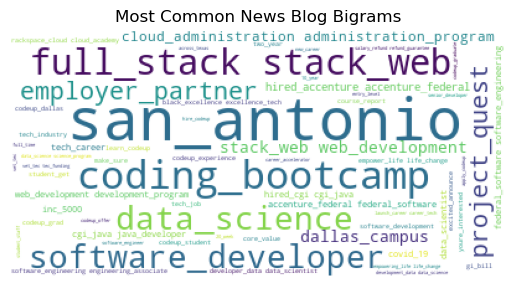

In [39]:
img = WordCloud(background_color='white').generate(' '.join(news_bi))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common News Blog Bigrams')
plt.show()

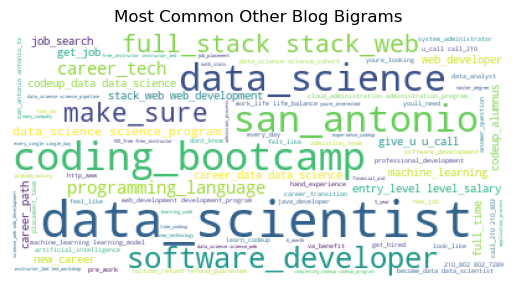

In [40]:
img = WordCloud(background_color='white').generate(' '.join(other_bi))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common Other Blog Bigrams')
plt.show()

In [41]:
news_tri = pd.Series(nltk.trigrams(news_blogs))
news_tri = news_tri.apply(lambda row: '_'.join([str(x) for x in row]))

other_tri = pd.Series(nltk.trigrams(other_blogs))
other_tri = other_tri.apply(lambda row: '_'.join([str(x) for x in row]))

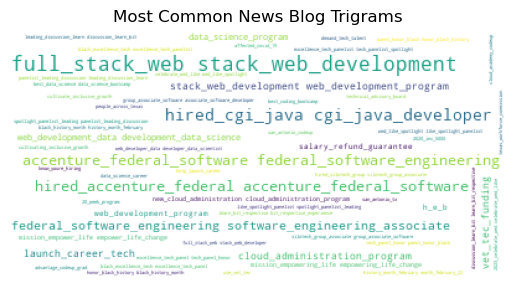

In [42]:
img = WordCloud(background_color='white').generate(' '.join(news_tri))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common News Blog Trigrams')
plt.show()

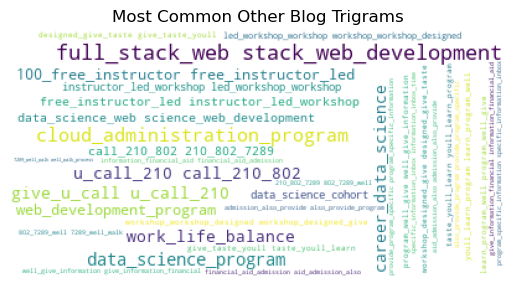

In [43]:
img = WordCloud(background_color='white').generate(' '.join(other_tri))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common Other Blog Trigrams')
plt.show()

## 3. Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.

In [44]:
df = a.get_shorts()
df.head()

title  \
0                       Apple could force 111-year-old Swiss firm to change its apple logo   
1                        Nissan's ex-CEO Carlos Ghosn sues automaker for $1 bn over ouster   
2  Financial influencer Ashesh & wife found running ₹300 cr drug racket, flee with ₹170 cr   
3                                     Rahul Shivshankar quits as Times Now Editor-in-Chief   
4                       Air India signs agreement with Airbus, Boeing for 470 new aircraft   

                                                                                                                                                                                                                                                                                                                                                                                                         content  \
0              Fruit Union Suisse, a 111-year-old Swiss company, is worried it might have to change its logo because Apple is trying to gain intellectual property rights over depictions of apples. "It's not like they're trying to protect their bitten apple...Their objective...is really to own rights to an actual apple, which...should be free for everyone to use," its director Jimmy Mariéthoz said.   
1                           Nissan's former CEO Carlos Ghosn has filed a $1-billion lawsuit against the Japanese automaker and connected individuals for ousting him in 2018 and arranging his arrest over alleged financial misconduct. Ghosn filed the lawsuit in Lebanon, where he has lived since escaping from Japan in 2019 to flee trial. In 2020, Nissan sued Ghosn for $90 million in monetary damages.   
2                            Financial influencer Ashesh Mehta and his wife Shivangi have been accused of running a ₹300 crore drug distribution network from their home. The couple is reported to have fled the country after transferring more than ₹170 crore earned through the sale of drugs into various bank accounts. A look-out circular has been issued against the couple by Madhya Pradesh police.    
3  Rahul Shivshankar has quit as the Editor-in-Chief of Times Now news channel, Newslaundry reported. "Rahul Shivshankar has decided to part ways with network...With immediate effect, the operations of the channel will be under the charge of Navika Kumar, Group Editor," an internal e-mail to employees reportedly said. Shivshankar joined the channel in 2016 after resigning as NewsX Editor-in-Chief.   
4                                              Air India on Tuesday finalised the agreements for the purchase of 470 aircraft from Boeing and Airbus at the 2023 Paris Air Show. "This landmark step further positions Air India for long-term growth and success that, we have every hope, will come together to represent the best of modern aviation to the world," Air India Chairman N Chandrasekaran said.   

   category  
0  Business  
1  Business  
2  Business  
3  Business  
4  Business

In [45]:
# rename content to original
df = df.rename(columns={'content':'original'})
# Derive column 'clean' from column: 'original'
df.insert(2, 'clean', df.apply(lambda row : p.remove_stopwords(p.tokenize(p.basic_clean(row.original)),"'"), axis=1))
# Derive column 'stemmed' from column: 'original'
df.insert(3, 'stem', df.apply(lambda row : p.stem(row.clean), axis=1))
# Derive column 'lemmatized' from column: 'original'
df.insert(4, 'lem', df.apply(lambda row : p.lemmatize(row.clean), axis=1))
df.sample(1)

title  \
11  Hyundai to invest over $85 billion by 2032, boost EV production   

                                                                                                                                                                                                                                                                                                                                 original  \
11  Hyundai Motor has announced it plans to invest over $85 billion in the period through 2032. It said it will allocate around a third of this towards the electric vehicles market to meet a "seismic change" in the industry. The South Korean automaker added that it is targeting the sale of two million EV units annually by 2030.   

                                                                                                                                                                                                                                  clean  \
11  hyundai motor announced plans invest 85 billion period 2032 said allocate around third towards electric vehicles market meet seismic change industry south korean automaker added targeting sale two million ev units annually 2030   

                                                                                                                                                                                                            stem  \
11  hyundai motor announc plan invest 85 billion period 2032 said alloc around third toward electr vehicl market meet seismic chang industri south korean automak ad target sale two million ev unit annual 2030   

                                                                                                                                                                                                                                 lem  \
11  hyundai motor announced plan invest 85 billion period 2032 said allocate around third towards electric vehicle market meet seismic change industry south korean automaker added targeting sale two million ev unit annually 2030   

    category  
11  Business

In [46]:
df.category.value_counts()

Sports           25
Technology       25
Entertainment    25
Business         24
Name: category, dtype: int64

In [47]:
busy = [word for row in df[df.category=="Business"]['lem'] for word in row.split()]
sports = [word for row in df[df.category=="Sports"]['lem'] for word in row.split()]
tech = [word for row in df[df.category=="Technology"]['lem'] for word in row.split()]
ent = [word for row in df[df.category=="Entertainment"]['lem'] for word in row.split()]
all_shorts = [word for row in df['lem'] for word in row.split()]

In [48]:
len(all_shorts), len(busy), len(sports), len(tech), len(ent)

(3631, 954, 967, 875, 835)

In [49]:
busy_freq = pd.Series(busy).value_counts()
sports_freq = pd.Series(sports).value_counts()
tech_freq = pd.Series(tech).value_counts()
ent_freq = pd.Series(ent).value_counts()
all_freq = pd.Series(all_shorts).value_counts()

In [50]:
word_counts = pd.concat([busy_freq, sports_freq, tech_freq, ent_freq, all_freq], axis=1).fillna(0).astype(int)
word_counts.columns = ['busy', 'sports','tech','ent','all']
word_counts.head()

busy  sports  tech  ent  all
said     15      17    17   31   80
india    12       6     7    3   28
order     9       0     0    0    9
crore     8       0     0    2   10
sebi      6       0     0    0    6

In [51]:
word_counts.sort_values('all',ascending=False)

busy  sports  tech  ent  all
said           15      17    17   31   80
india          12       6     7    3   28
added           5       9     4    9   27
year            5       8     4    4   21
actor           0       0     0   18   18
...           ...     ...   ...  ...  ...
celebrate       0       1     0    0    1
root            0       1     0    0    1
roman           0       1     0    0    1
universal       0       1     0    0    1
comfortable     0       0     0    1    1

[1847 rows x 5 columns]

<Axes: >

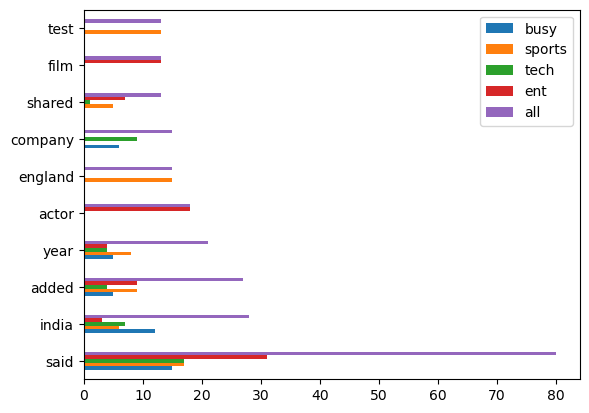

In [52]:
word_counts.sort_values('all', ascending=False).head(10).plot.barh()

In [53]:
df['sentiment'] = df['original'].apply(lambda doc: sia.polarity_scores(doc)['compound'])
df.groupby('category').sentiment.agg(['mean','median'])

mean   median
category                        
Business       0.158500  0.12665
Entertainment  0.174052  0.36120
Sports         0.460120  0.58590
Technology     0.221712  0.36120

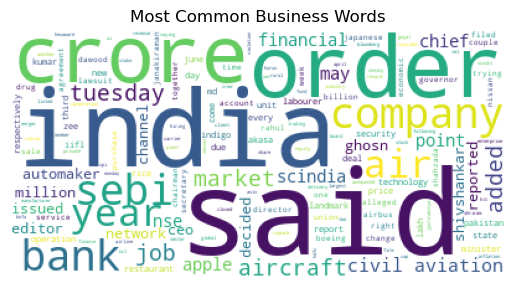

In [54]:
img = WordCloud(background_color='white').generate(' '.join(busy))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common Business Words')
plt.show()

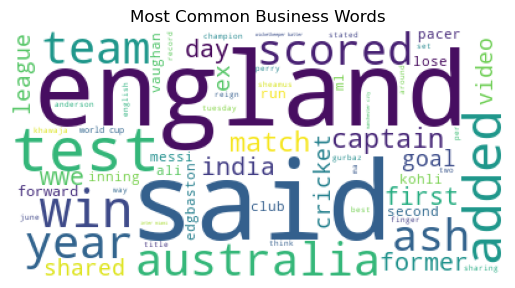

In [55]:
img = WordCloud(background_color='white').generate(' '.join(sports))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common Business Words')
plt.show()

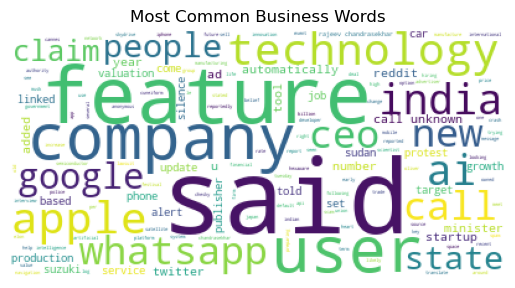

In [56]:
img = WordCloud(background_color='white').generate(' '.join(tech))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common Business Words')
plt.show()

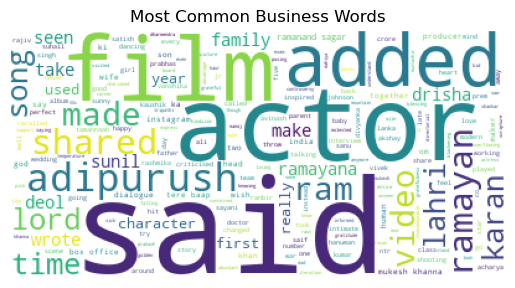

In [57]:
img = WordCloud(background_color='white').generate(' '.join(ent))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common Business Words')
plt.show()

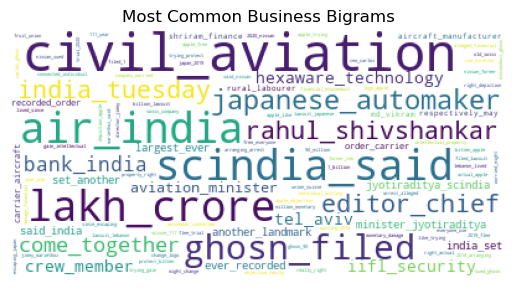

In [58]:
busy_bi = pd.Series(nltk.bigrams(busy))
busy_bi = busy_bi.apply(lambda row: '_'.join([str(x) for x in row]))

img = WordCloud(background_color='white').generate(' '.join(busy_bi))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common Business Bigrams')
plt.show()

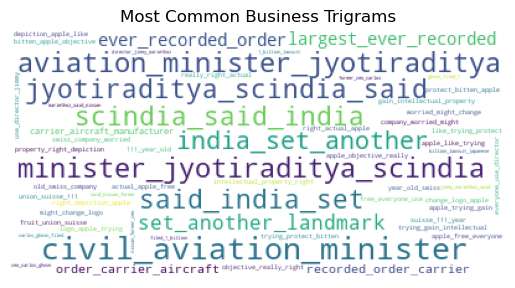

In [59]:
busy_tri = pd.Series(nltk.trigrams(busy))
busy_tri = busy_tri.apply(lambda row: '_'.join([str(x) for x in row]))

img = WordCloud(background_color='white').generate(' '.join(busy_tri))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common Business Trigrams')
plt.show()

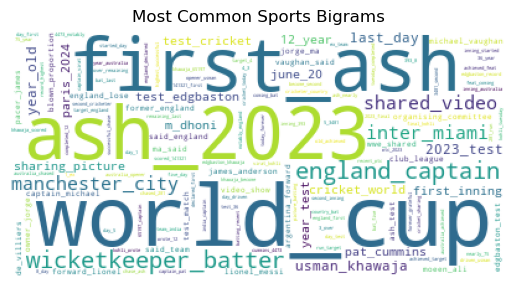

In [60]:
sports_bi = pd.Series(nltk.bigrams(sports))
sports_bi = sports_bi.apply(lambda row: '_'.join([str(x) for x in row]))

img = WordCloud(background_color='white').generate(' '.join(sports_bi))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common Sports Bigrams')
plt.show()

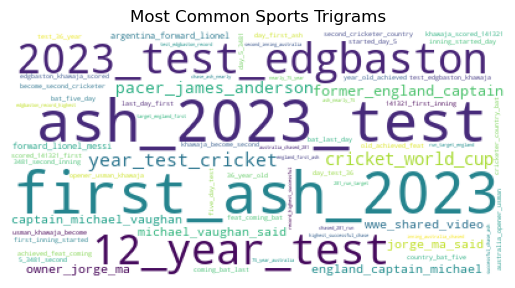

In [61]:
sports_tri = pd.Series(nltk.trigrams(sports))
sports_tri = sports_tri.apply(lambda row: '_'.join([str(x) for x in row]))

img = WordCloud(background_color='white').generate(' '.join(sports_tri))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common Sports Trigrams')
plt.show()

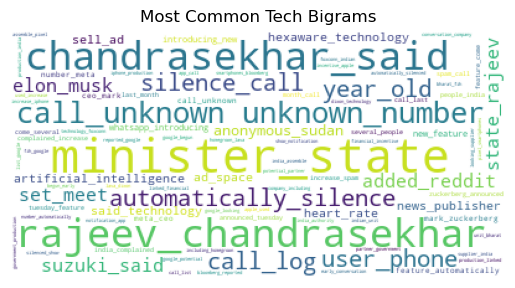

In [62]:
tech_bi = pd.Series(nltk.bigrams(tech))
tech_bi = tech_bi.apply(lambda row: '_'.join([str(x) for x in row]))

img = WordCloud(background_color='white').generate(' '.join(tech_bi))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common Tech Bigrams')
plt.show()

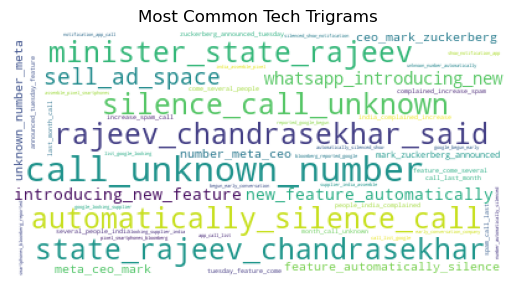

In [63]:
tech_tri = pd.Series(nltk.trigrams(tech))
tech_tri = tech_tri.apply(lambda row: '_'.join([str(x) for x in row]))

img = WordCloud(background_color='white').generate(' '.join(tech_tri))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common Tech Trigrams')
plt.show()

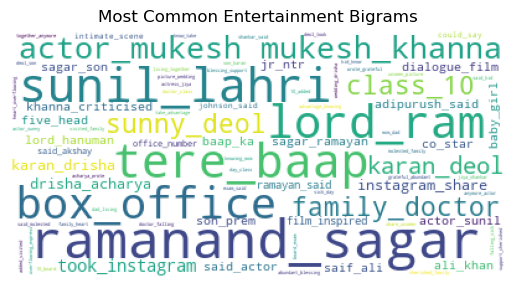

In [64]:
ent_bi = pd.Series(nltk.bigrams(ent))
ent_bi = ent_bi.apply(lambda row: '_'.join([str(x) for x in row]))

img = WordCloud(background_color='white').generate(' '.join(ent_bi))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common Entertainment Bigrams')
plt.show()

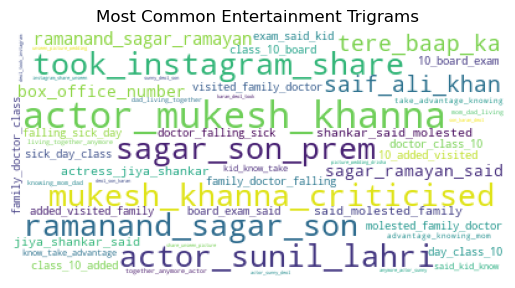

In [65]:
ent_tri = pd.Series(nltk.trigrams(ent))
ent_tri = ent_tri.apply(lambda row: '_'.join([str(x) for x in row]))

img = WordCloud(background_color='white').generate(' '.join(ent_tri))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common Entertainment Trigrams')
plt.show()